# Using EDP API to request ESG data on Jupyter Notebook

## INTRODUCTION

Environmental, Social and Governance (ESG) is a set of standards for a company's operations that investors use to evaluate corporate behavior, determine the future financial performance and decide whether it will be beneficial to invest in a company or not. The ESG information from Refinitv enables our clients to benchmark, compare and integrate extra-financial information into their investment processes to identify companies with quality management and reduced risk exposure. Please refer to the [ESG Learning Section](https://developers.refinitiv.com/elektron-data-platform/elektron-data-platform-apis/learning?content=62732&type=learning_material_item) on the [Developer Community](https://developers.refinitiv.com/) for more details about the ESG data and its coverage provided by Refinitiv.

This article will demonstrate how we can retrieve [ESG data](https://developers.refinitiv.com/content/edp-esg-quick-start-video) from [Elektron Data Platform (EDP)](https://developers.refinitiv.com/elektron-data-platform/elektron-data-platform-apis). We will be using Python with EDP API to request ESG data on the [Jupyter Notebook](https://jupyter.org/index.html). The notebook allows the user to create and share documents that contain live code, narrative text, visualizations and we can also plot the graph on the notebook.

The Jupyter Notebook with Python codes will be provided on GitHub.

## PRE-REQUISITES:

* Python 3.6 or later version.
* Required Python Packages: getpass, json, requests, pandas, numpy, matplotlib.
* [Jupyter Notebook](https://jupyter.org/install). You can install Jupyter Notebook on your local machine and then test the example on the machine. Alternate choice is a free Juputer Notebook on cloud environment such as [Azure Notebook](https://notebooks.azure.com/) provided by Microsoft. You can find more details from [this tutorial](https://docs.microsoft.com/en-us/azure/notebooks/tutorial-create-run-jupyter-notebook).
* EDP account with a permission to access ESG basic or premium data. 

## IMPREMENTATIONS

There are two main steps for the implementation according to [the tutorial](https://developers.refinitiv.com/elektron-data-platform/elektron-data-platform-apis/learning?content=62732&type=learning_material_item).

* Get Access Token from EDP Authentication Endpoint.
* Get specific ESG data like the basic score from the REST endpoint. 
* Display data and plot a graph.


### Get Access Token

__Get EDP Username and Password__

The user must have a valid EDP account with a permission to access ESG data. The application will use getpass to get the username and password from user.

In [3]:
import getpass as gp

username=input('Enter EDP username:')
password=gp.getpass('Enter EDP Password:')

Enter EDP username:GE-A-01103867-3-1175
Enter EDP Password:········


__Get access token from authentication endpoint__

The application send HTTP post and pass required parameter according to the [EDP tutorial](https://developers.refinitiv.com/elektron-data-platform/elektron-data-platform-apis/learning?content=38562&type=learning_material_item) to get the Access Token from EDP server.


In [4]:
from json import dumps, loads, load
from requests import post,get

#Get access token from EDP server 
getTokenEndpoint="https://api.refinitiv.com/auth/oauth2/beta1/token"
refreshToken=None
accessToken=None
_header= {}
_header['Accept']='application/json'
_params={}

if refreshToken is None:
    _params={
        "username": username,
        "password": password,
        "grant_type": "password",
        "scope": "trapi",
        "takeExclusiveSignOnControl": "true"
    }
else:
    _params={
			"refresh_token": refreshToken,
			"username": username,
			"grant_type": "refresh_token"
    }

resp=post(url=getTokenEndpoint,data=_params,headers=_header,auth=(username,""))

If the returned status code from HTTP response is not 200 (OK), we assume that there is an error occurred, therefore, the application will print the status code and the response status message then exit the application. Otherwise, get the Refresh Token and Access Token from the HTTP response message and print it out.

In [5]:
if resp.status_code!=200:
    print("Status Code:",resp.status_code," Text:",dumps(loads(resp.text),indent=4))
    exit()
else:
    #print(dumps(loads(resp.text),indent=4))
    from collections import OrderedDict
    auth_object=loads(resp.text,object_pairs_hook=OrderedDict)
    accessToken=auth_object["access_token"]
    refreshToken=auth_object["refresh_token"]

print("Refresh Token:",refreshToken)
print("Access Token:",accessToken)

Refresh Token: 324e5192-bff1-46e4-b2e1-0ed30ff77fc1
Access Token: eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6IjNKZnZZOWNYaEtoVndDRmU1a29MdWpPektQdnNtUnZ0TXRXMHZYYWpqVXcifQ.eyJkYXRhIjoie1wiY2lwaGVydGV4dFwiOlwiUUZVV2dmUVBfU3hnby1sNi1tbUlHRkdVQkUwYmZIQmI1QzdOVmV4OGx3a0VOWlRDTzB0N3RjOFRISHdId2lIbUVUZXE2Y2lkOFR0RGo2UmZNektpdXBpNjJ0MWpkT0VINWtmUjUySlU0Y3ZjN2M2c21KODE2MXRpUWttemZlNzFEaXlrTmwzejZnODdjVzJIb2hjeHR3MEJRWTM5VTdTTHphR2FqQ1hjeldNVzRQMDQyemg5VWdTeHVKaEtudm9Bd1NNbUdSM1M2VVRsNThwUXVEMXlWVmJpYThQdUloWE9uNE1wdGpFcFlMcFNINFdXX3k1WFJ6VjBhT2U1U2ZBMlY3bDAyeTkyX1U3N0ZjVFBQQjYyS3VxZ0NTelo2UHlMV2hKczI2T0ROUkdRZ1VYYWRaV3lVQmJycDJQTTJrV2pSbGotOTEwc0lSQzg4WFA3RWtlbFItT1dZRFV5ZE12N21TdXZqaFVmSGE3NnJ2aHB2VGtnbDVpWk1JZGhoek5CQURIZVhUdVFQOFlZTU1GS1dPWUhGdjhZRVRXck0zSVRBTXQxZ2tManVPYXpHTU5JeV9DRnk5MmdGN2FfWFpSeHRQVi0zSzNXLXpGZGdBTDloa3NkRmN2MWliSjIwUjItY01yOWxtTVVIVmRQX1JZclN4VnN4UzE3VlduNDd1T2V5LXZ1d0V6dkl3SVpSbjlXN09VMFNsVExBWVpxRTFuckYydDRHd3A4VTlBa084ME9NZzN6TWZ3WlVnWlM1di15MnB3UGp0ZVpOeTR5bVRuNkd

### Retreive ESG score

In this example, we want to retrieve the ESG Score standard. The score standard operation returns all available scores for a company with three years of historical data. Application has to use the following Endpoint to retrieve the data.

```html
https://api.refinitiv.com/data/environmental-social-governance/v1/views/scores-standard
```
There is an alternate option for a professional account to get ESG data with full score and it returns scores with full history. The user can use the following Endpoint instead.

```html
https://api.refinitiv.com/data/environmental-social-governance/v1/views/scores-full
```
The application has to send the server certain GET parameters through the requested endpoint/URL. In this case, it has to pass a universe as HTTP get parameters. The universe could be RIC name or ISIN or any other supported value.  
The application needs to set a Bearer access token in the Authorization header of the HTTP request message. See below snippet of codes for the API usage to request full ESG score for the RIC MSFT.O.

In [6]:
ricList="MSFT.O"
esgScoreFullEndpoint="https://api.refinitiv.com/data/environmental-social-governance/v1/views/scores-full?universe="
resp=get(url=esgScoreFullEndpoint+ricList,headers={"Authorization": "Bearer " + accessToken})

if resp.status_code!=200:
    print("Status Code:",resp.status_code," Text:",dumps(loads(resp.text),indent=4))
    exit()

esg_object=loads(resp.text)

To process the ESG data, we need to convert the data from JSON object to a pandas data frame. The application need to get the data and column name from JSON object and then re-construct a new dataframe. The applicaiton need to converts the title from a header to numpy arrary and convert data array to numpy array as well. 

In [7]:
import pandas as pd
import numpy as np
headers=esg_object['headers']
titles=np.array([])

for header in headers:
    titles=np.append(titles,header['title'])

dataArray=np.array(esg_object['data'])
df=pd.DataFrame(data=dataArray,columns=titles)


It should return the data like the following sample output.

In [8]:
print(df)

   Instrument Period End Date ESG Combined Score ESG Score  \
0      MSFT.O      2017-06-30            46.6738   92.5464   
1      MSFT.O      2016-06-30            48.0373   94.0451   
2      MSFT.O      2015-06-30            47.5047   91.2885   
3      MSFT.O      2014-06-30            46.9122   92.4452   
4      MSFT.O      2013-06-30            46.8311   92.4993   
5      MSFT.O      2012-06-30            44.6859   86.8295   
6      MSFT.O      2011-06-30            45.8584   90.4125   
7      MSFT.O      2010-06-30            46.4708   91.6484   
8      MSFT.O      2009-06-30            46.2809   91.1054   
9      MSFT.O      2008-06-30            44.3057   85.6702   
10     MSFT.O      2007-06-30            45.7609   88.8901   
11     MSFT.O      2006-06-30            38.0189   73.4404   
12     MSFT.O      2005-06-30            69.1562   69.1562   
13     MSFT.O      2004-06-30            33.8568   66.8939   
14     MSFT.O      2003-06-30            27.3133   50.3409   
15     M

### Plot Graph from ESG Score

To compare specific ESG data between the years, Jupyter Notebook user may use the mathplotlib to plot the graph.

For this example, we want to compare columns "ESG Score","ESG Combined Score" and "Innovation Score" between the years. I have to create a new data frame from the origina data frame df using the following codes.

In [9]:
dataPlot=pd.DataFrame(df,columns=['Instrument','Period End Date','ESG Score','ESG Combined Score','Innovation Score'])

The data for the Y-axis is a Period End Date and the X-axis is the ESG scores. We want to display only the year (eg "2017", "2016") therefore we need to reformat the data in "Period End Date" column using below codes. The example also sorting the year ascending. 

Note that you can change the column in dataPlot to plot the graph for specific data you want. If you have permission to request only a basic score you might need to change the column accordingly.

In [10]:
dataPlot['Period End Date']= dataPlot['Period End Date'].str.split('-').str[0]
dataPlot.sort_values('Period End Date',ascending=True,inplace=True)

It will be displaying the following sample graphs on the notebook.

In [11]:
dataPlot.plot(x='Period End Date',y=['ESG Score','ESG Combined Score','Innovation Score'],figsize=(14,7))
dataPlot.plot(x='Period End Date',y=['ESG Score','ESG Combined Score','Innovation Score'],kind='bar',figsize=(14,7))

### Compare ESG Score for multiple universe

The next step, I'm interested in comparing the value of a number of Woman Manager and CO2 Emission Total used by a top tech company such as Microsoft, IBM, Facebook, Google/Alphabet, and Amazon. 

Based on the details from EDP Swagger page,  we can get the data using basic score endpoint and we just need to pass a list of RIC for each company as a universe parameters. Below are a snippet of codes to demonstrate the API usage.

In [12]:
ricList="IBM,AMZN.O,MSFT.O,GOOGL.O,FB.O,APPL.O"
esgฺBasicEndpoint="https://api.refinitiv.com/data/environmental-social-governance/v1/views/basic?universe="
resp=get(url=esgฺBasicEndpoint+ricList,headers={"Authorization": "Bearer " + accessToken})
if resp.status_code!=200:
    print("Status Code:",resp.status_code," Text:",dumps(loads(resp.text),indent=4))
    exit()

esg_BasicObject=loads(resp.text)

import pandas as pd
import numpy as np
headers=esg_BasicObject['headers']
titles=np.array([])

for header in headers:
    titles=np.append(titles,header['title'])

basicDataArray=np.array(esg_BasicObject['data'])
basicDf=pd.DataFrame(data=basicDataArray,columns=titles)

Print sample basic score result.

In [13]:
print(basicDf)

  Instrument Period End Date ESG Reporting Scope  \
0        IBM      2017-12-31                 100   
1     AMZN.O      2017-12-31                 100   
2    GOOGL.O      2017-12-31                 100   
3       FB.O      2017-12-31                 100   
4     MSFT.O      2017-06-30                 100   

              ESG Report Auditor Name ESG Period Last Update Date  \
0                                None         2019-03-30T00:00:00   
1                                None         2019-05-11T00:00:00   
2                                None         2019-05-04T00:00:00   
3  Bureau Veritas North America, Inc.         2019-05-04T00:00:00   
4                                None         2019-04-19T00:00:00   

  CO2 Equivalents Emission Total Women Managers Average Training Hours  
0                        1496517           None                 59.578  
1                           None             26                   None  
2                        3367941           25.5      

__Display Componay Name__

We have an additional requirement to display Company Name rather than using RIC codes. Basically, the data returned by the ESG basic score has only an Instrument name but it does not have a company named. Therefore, I need to create a function for getting the company name from ESG universe data. I found that the ESG universe endpoint can provide the company names that I want. I will use it later when I plot the graph. Anyway, we found that we can't find some RIC code using the universe Endpoint so it will return the original RIC name instead.


In [14]:
esgUniverseEndpoint="https://api.refinitiv.com/data/environmental-social-governance/v1/universe"

resp=get(url=esgUniverseEndpoint,headers={"Authorization": "Bearer " + accessToken})
if resp.status_code!=200:
    print("Status Code:",resp.status_code," Text:",dumps(loads(resp.text),indent=4))
    exit()

esg_universe = loads(resp.text)

def GetRicName(ricName):
    universe_data = [sublist for sublist in esg_universe['data'] if sublist[1]==ricName] 
    #print(universe_data)
    if universe_data:
        return universe_data[0][2]
    return None


Display Company Name for MSFT.O ric.

In [27]:
print("MSFT.O is \""+ GetRicName("MSFT.O")+"\"")

MSFT.O is "Microsoft Corp"


Next step we will be using the data from a **basicDf** dataframe to plot horizontal bar chart for comparing a **Woman Managers** and **CO2 Emission Total** from each company. Base on a result from a dataframe, we found that column number 5 is a data for "**CO2 Equivalents Emission Total**" and column number 6 is a data for "**Women Managers**", then we will use the index to extract the data. Below are the codes we use to extract both data from the data frame.

In [16]:
# Extract CO2, Woman Manager and Instrument from the dataframe and convert to numpy array
co2= [val for sublist in np.array(basicDf.iloc[:,5:6]) for val in sublist]

woman=[val for sublist in np.array(basicDf.iloc[:,6:7]) for val in sublist] 

instrument=[val for sublist in np.array(basicDf.iloc[:,0:1]) for val in sublist]  


Print data inside co2,woman and instrument variable.

In [24]:
print(co2)
print(woman)
print(instrument)

[1496517, None, 3367941, 638000, 2790348]
[None, 26, 25.5, 28, 19.1]
['IBM', 'AMZN.O', 'GOOGL.O', 'FB.O', 'MSFT.O']


Next step we need to get a company name for each instrument from the instrument list.

In [18]:
instrumentorg=np.array([])

for val in instrument:
    if GetRicName(val) is None:
        instrumentorg=np.append(instrumentorg,val)
    else:
        instrumentorg=np.append(instrumentorg,GetRicName(val))

Display instrument name.

In [19]:
print(instrumentorg)

['International Business Machines Corp' 'Amazon.com Inc' 'Alphabet Inc'
 'Facebook Inc' 'Microsoft Corp']


The last step we construct dataframe for plotting the graph for displaying a data for **CO2 Emission Total** with a **Woman Managers** separately because of the difference between the scale of each data. We will be using the company name as an index.

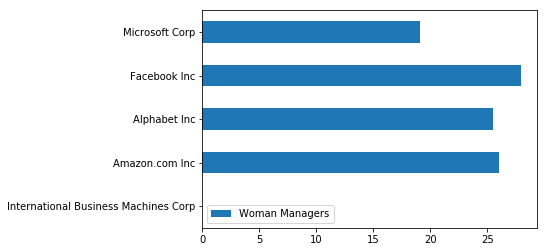

In [20]:
df1 = pd.DataFrame({"Woman Managers":woman}, index=instrumentorg)
df1.plot.barh(y='Woman Managers')

It looks like currently we do not have "Woman Managers" report for IBM.

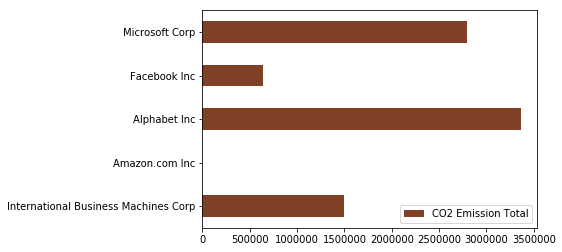

In [21]:
df2 = pd.DataFrame({"CO2 Emission Total":co2}, index=instrumentorg)
df2.plot.barh(y='CO2 Emission Total',color=(0.5, 0.25, 0.15, 1))

For CO2 Emision Totla, it looks like currently we do not have a CO2 report for Amazon.
You can change or modify Python codes in this notebook to displaying data from other columns of the dataframe for basic or full ESG Score.

## REFERENCES

* [Elektron Data Platform Document](https://developers.refinitiv.com/elektron-data-platform/elektron-data-platform-apis/docs)
* [Elektron Data Platform Tutorial](https://developers.refinitiv.com/elektron-data-platform/elektron-data-platform-apis/learning)
* [ESG User Guide](https://developers.refinitiv.com/elektron-data-platform/elektron-data-platform-apis/docs?content=62652&type=documentation_item)

## DOWNLOADS
* Github